### Notebook boilerplate

In [3]:
from pathlib import Path
notebooks_dir = Path('.').resolve()
root_dir = notebooks_dir.parents[0]
import sys
sys.path.append(str(root_dir))
from settings import *
def fix_path(path):
    """Hacky fix to make paths behave when importing from upstream module"""
    return Path(str(path).replace('notebooks/', ''))
PROCESSED_DIR = fix_path(PROCESSED_DIR)
INTERIM_DIR = fix_path(INTERIM_DIR)
MODELS_DIR = fix_path(MODELS_DIR)

In [4]:
from importlib import reload
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import linearcorex as lc
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Install CUDA and cudamat (for python) to enable GPU speedups.


In [5]:
def find_elbow(s: pd.Series, keep='last')->dict:
    """Find the number of components at the elbow of a BIC scree plot"""
    if type(s) is not pd.Series:
        raise TypeError('Must provide Pandas Series object as an argument')
    frame = s.rename('bic').to_frame()
    frame['bic_pct_change'] = frame['bic'].pct_change()
    frame['bic_pct_change2'] = frame['bic_pct_change'].pct_change()
    frame['criteria_1'] = frame['bic_pct_change2'] < 0
    frame['criteria_2'] = frame['bic_pct_change2'].shift(1) > 0
    frame['criteria_3'] = frame['bic_pct_change'].shift(-1) < frame['bic_pct_change']
    frame['criteria_4'] = frame.isnull().sum(axis=1) == 0
    frame['criteria_5'] = frame.shift(-1)['bic_pct_change'] < 0
    frame['score'] = frame.loc[:, 'criteria_1': 'criteria_5'].sum(axis=1)
    return {'elbow': frame.drop_duplicates('score', keep=keep)['score'].idxmax(), 'scores': frame}


def label_data(frame, model):
    frame['cluster'] = model.predict(X)
    ix = ['geoid', 'state_abbr', 'logrecno', 'geo_label', 'cluster']
    return frame.reset_index().set_index(ix)


def train_gaussian_mixture_models(X: np.array,
                                 n_components_li,
                                 random_state,
                                 verbose=False):
    """Train a set of Gaussian Mixture models and summary statistics for each model"""
    gm_outputs = {}
    for n_components in n_components_li:
        gm = GaussianMixture(n_components=n_components,
                            n_init=1,
                            covariance_type='full',
                            warm_start=True,
                            verbose=verbose,
                            random_state=random_state)
        gm.fit(X)
        aic = gm.aic(X)
        bic = gm.bic(X)
        if verbose:
            print(f'n_components={n_components}, AIC={round(aic)}, BIC={round(bic)})')
        gm_outputs[n_components] = {'model': gm, 'aic': aic, 'bic': bic}
    return gm_outputs


src = PROCESSED_DIR / 'scaled_imputed_data.pkl'
orig_src = INTERIM_DIR / 'acs__preprocessed_tables.pkl'
corex_obj_src = PROCESSED_DIR / 'selected_n_components.pkl'
gm_dst = MODELS_DIR / 'gaussian_mixture.pkl'
ce_dst = MODELS_DIR / 'corex.pkl'
labeled_dst = PROCESSED_DIR / 'labeled.pkl'
labeled_orig_dst = PROCESSED_DIR / 'labeled_orig.pkl'
figsize = (8, 4)
sns.set()


### Load data

In [6]:
df_orig = pd.read_pickle(orig_src)
df = pd.read_pickle(src)
with open(str(corex_obj_src), 'rb') as f:
    corex_obj = pickle.load(f)
selected_n_components = corex_obj['n_components']

In [7]:
selected_n_components

19

### Train Corex model

In [5]:
ce_model = lc.Corex(n_hidden=selected_n_components, gaussianize='outliers', verbose=True, seed=RANDOM_STATE)
ce_model.fit(df.sample(N_SAMPLES, random_state=RANDOM_STATE, replace=True).values)

Linear CorEx with 19 latent factors
895 iterations to tol: 0.000010, TC=250.546120
317 iterations to tol: 0.000010, TC=434.846882
58 iterations to tol: 0.000010, TC=554.895000
18 iterations to tol: 0.000010, TC=635.285477
19 iterations to tol: 0.000010, TC=695.014568
34 iterations to tol: 0.000010, TC=747.083988
6 iterations to tol: 0.000010, TC=895.495949


### Map hidden layers to original features

In [6]:
index = [x+1 for x in range(selected_n_components)]
ce_map = pd.Series(ce_model.clusters(), index=df.columns, name='component').to_frame().sort_index().sort_values(by='component')
ce_map

,component
housing__b25013__total,0
hh_fams__b11007__households_with_no_people_65_years_and_over,0
inc__b19054__no_interest_dividends_or_net_rental_income,0
hh_fams__b11001__total,0
housing__b25128__total,0
...,...
mi__fertility__b13002a__now_married_(including_separated_and_spouse_absent),18
mi__fertility__b13002a__total,18
mi__fertility__b13002a__women_who_did_not_have_a_birth_in_the_past_12_months,18
mi__hh_fams__b11004__total,18


#### Components:
* 0: Missing age and sex demos
* 1: Family, health insurance, disability, fertility, school enrollment
* 2: Missing native birthplace demos
* 3: Missing school enrollment
* 4: Income, housing
* 5: Missing educational attainment
* 6: Fertility and health
* 7: Missing housing

* 13: Demos for the elderly

In [1]:
ce_map

NameError: name 'ce_map' is not defined

In [7]:
[print(feature) for feature, _ in ce_map.query('component==0').sort_index().iterrows()]
print('---')

hh_fams__b11001__total
hh_fams__b11007__households_with_no_people_65_years_and_over
hh_fams__b11007__total
hh_fams__b11015__households_with_no_nonrelatives
hh_fams__b11015__total
housing__b25001__total
housing__b25002__occupied
housing__b25002__total
housing__b25003__total
housing__b25013__total
housing__b25128__total
inc__b19051__total
inc__b19051__with_earnings
inc__b19052__total
inc__b19052__with_wage_or_salary_income
inc__b19053__no_self-employment_income
inc__b19053__total
inc__b19054__no_interest_dividends_or_net_rental_income
inc__b19054__total
inc__b19055__no_social_security_income
inc__b19055__total
inc__b19056__no_supplemental_security_income_(ssi)
inc__b19056__total
inc__b19057__no_public_assistance_income
inc__b19057__total
inc__b19058__no_cash_public_assistance_or_food_stampssnap
inc__b19058__total
inc__b19059__no_retirement_income
inc__b19059__total
inc__b19060__no_other_types_of_income
inc__b19060__total
transfer_progs__b22001__household_did_not_receive_food_stampssnap_i

In [8]:
factor = 1
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 1
mi__age_sex__b01001a__10_to_14_years
mi__age_sex__b01001a__15_to_17_years
mi__age_sex__b01001a__18_and_19_years
mi__age_sex__b01001a__20_to_24_years
mi__age_sex__b01001a__25_to_29_years
mi__age_sex__b01001a__30_to_34_years
mi__age_sex__b01001a__35_to_44_years
mi__age_sex__b01001a__45_to_54_years
mi__age_sex__b01001a__55_to_64_years
mi__age_sex__b01001a__5_to_9_years
mi__age_sex__b01001a__65_to_74_years
mi__age_sex__b01001a__75_to_84_years
mi__age_sex__b01001a__85_years_and_over
mi__age_sex__b01001a__female
mi__age_sex__b01001a__male
mi__age_sex__b01001a__total
mi__age_sex__b01001a__under_5_years
---


In [9]:
[print(feature) for feature, _ in ce_map.query('component==2').sort_index().iterrows()]
print('---')

mi__native_birthplace__b06001__18_to_24_years
mi__native_birthplace__b06001__25_to_34_years
mi__native_birthplace__b06001__35_to_44_years
mi__native_birthplace__b06001__45_to_54_years
mi__native_birthplace__b06001__55_to_59_years
mi__native_birthplace__b06001__5_to_17_years
mi__native_birthplace__b06001__60_and_61_years
mi__native_birthplace__b06001__62_to_64_years
mi__native_birthplace__b06001__65_to_74_years
mi__native_birthplace__b06001__75_years_and_over
mi__native_birthplace__b06001__born_in_other_state_in_the_united_states
mi__native_birthplace__b06001__born_in_state_of_residence
mi__native_birthplace__b06001__foreign_born
mi__native_birthplace__b06001__native;_born_outside_the_united_states
mi__native_birthplace__b06001__total
mi__native_birthplace__b06001__under_5_years
---


In [10]:
factor = 3
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 3
mi__school_enroll__b14001__enrolled_in_college_undergraduate_years
mi__school_enroll__b14001__enrolled_in_grade_1_to_grade_4
mi__school_enroll__b14001__enrolled_in_grade_5_to_grade_8
mi__school_enroll__b14001__enrolled_in_grade_9_to_grade_12
mi__school_enroll__b14001__enrolled_in_kindergarten
mi__school_enroll__b14001__enrolled_in_nursery_school_preschool
mi__school_enroll__b14001__enrolled_in_school
mi__school_enroll__b14001__graduate_or_professional_school
mi__school_enroll__b14001__not_enrolled_in_school
mi__school_enroll__b14001__total
mi__school_enroll__b14002__enrolled_in_college_undergraduate_years
mi__school_enroll__b14002__enrolled_in_grade_1_to_grade_4
mi__school_enroll__b14002__enrolled_in_grade_5_to_grade_8
mi__school_enroll__b14002__enrolled_in_grade_9_to_grade_12
mi__school_enroll__b14002__enrolled_in_graduate_or_professional_school
mi__school_enroll__b14002__enrolled_in_kindergarten
mi__school_enroll__b14002__enrolled_in_nursery_school_preschool
mi__school_enrol

In [11]:
factor = 4
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 4
age_sex__b01003__total
disability__b18101__35_to_64_years
disability__b18101__5_to_17_years
disability__b18101__female
disability__b18101__male
disability__b18101__total
disability__b18101__under_5_years
disability__b18102__35_to_64_years
disability__b18102__5_to_17_years
disability__b18102__female
disability__b18102__male
disability__b18102__total
disability__b18102__under_5_years
emp_status__b23010__with_own_children_of_the_householder_under_18_years
emp_status__b23018__male
fertility__b13002__now_married_(including_separated_and_spouse_absent)
fertility__b13002__women_who_had_a_birth_in_the_past_12_months
fertility__b13004__now_married_(including_separated_and_spouse_absent)
fertility__b13004__women_who_had_a_birth_in_the_past_12_months
fertility__b13008__now_married_(including_separated_and_spouse_absent)
fertility__b13008__women_who_had_a_birth_in_the_past_12_months
fertility__b13010__now_married_(including_separated_and_spouse_absent)
fertility__b13010__women_who_had_a_b

In [12]:
factor = 5
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 5
mi__edu_attain__b15011__25_to_39_years
mi__edu_attain__b15011__40_to_64_years
mi__edu_attain__b15011__65_years_and_over
mi__edu_attain__b15011__arts_humanities_and_other
mi__edu_attain__b15011__business
mi__edu_attain__b15011__education
mi__edu_attain__b15011__female
mi__edu_attain__b15011__male
mi__edu_attain__b15011__science_and_engineering
mi__edu_attain__b15011__science_and_engineering_related_fields
mi__edu_attain__b15011__total
---


In [13]:
factor = 6
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 6
mi__fertility__b13002__15_to_19_years_old
mi__fertility__b13002__20_to_34_years_old
mi__fertility__b13002__35_to_50_years_old
mi__fertility__b13002__now_married_(including_separated_and_spouse_absent)
mi__fertility__b13002__total
mi__fertility__b13002__unmarried_(never_married_widowed_and_divorced)
mi__fertility__b13002__women_who_did_not_have_a_birth_in_the_past_12_months
mi__fertility__b13002__women_who_had_a_birth_in_the_past_12_months
mi__fertility__b13016__15_to_19_years_old
mi__fertility__b13016__20_to_24_years_old
mi__fertility__b13016__25_to_29_years_old
mi__fertility__b13016__30_to_34_years_old
mi__fertility__b13016__35_to_39_years_old
mi__fertility__b13016__40_to_44_years_old
mi__fertility__b13016__45_to_50_years_old
mi__fertility__b13016__total
mi__fertility__b13016__women_who_did_not_have_a_birth_in_the_past_12_months
mi__fertility__b13016__women_who_had_a_birth_in_the_past_12_months
---


In [14]:
factor = 7
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 7
mi__housing__b25128__householder_15_to_34_years
mi__housing__b25128__householder_35_to_64_years
mi__housing__b25128__householder_65_years_and_over
mi__housing__b25128__moved_in_1989_or_earlier
mi__housing__b25128__moved_in_1990_to_1999
mi__housing__b25128__moved_in_2000_to_2009
mi__housing__b25128__moved_in_2010_to_2014
mi__housing__b25128__moved_in_2015_to_2016
mi__housing__b25128__moved_in_2017_or_later
mi__housing__b25128__owner_occupied
mi__housing__b25128__renter_occupied
mi__housing__b25128__total
---


In [15]:
factor = 8
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 8
mi__hh_fams__b11003__6_to_17_years_only
mi__hh_fams__b11003__female_householder_no_husband_present
mi__hh_fams__b11003__male_householder_no_wife_present
mi__hh_fams__b11003__married-couple_family
mi__hh_fams__b11003__no_own_children_of_the_householder_under_18_years
mi__hh_fams__b11003__other_family
mi__hh_fams__b11003__total
mi__hh_fams__b11003__under_6_years_and_6_to_17_years
mi__hh_fams__b11003__under_6_years_only
mi__hh_fams__b11003__with_own_children_of_the_householder_under_18_years
---


In [16]:
factor = 9
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 9
mi__marital_status__b12001__divorced
mi__marital_status__b12001__female
mi__marital_status__b12001__male
mi__marital_status__b12001__married_spouse_absent
mi__marital_status__b12001__married_spouse_present
mi__marital_status__b12001__never_married
mi__marital_status__b12001__now_married
mi__marital_status__b12001__other
mi__marital_status__b12001__separated
mi__marital_status__b12001__total
mi__marital_status__b12001__widowed
---


In [17]:
factor = 10
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 10
disability__b18101__18_to_34_years
disability__b18102__18_to_34_years
emp_status__b23018__aggregate_usual_hours
emp_status__b23018__female
fertility__b13002__15_to_19_years_old
fertility__b13002__20_to_34_years_old
fertility__b13002__35_to_50_years_old
fertility__b13002__total
fertility__b13002__unmarried_(never_married_widowed_and_divorced)
fertility__b13002__women_who_did_not_have_a_birth_in_the_past_12_months
fertility__b13004__not_an_unmarried_partner
fertility__b13004__total
fertility__b13004__unmarried_(never_married_widowed_and_divorced)
fertility__b13004__women_who_did_not_have_a_birth_in_the_past_12_months
fertility__b13008__native
fertility__b13008__total
fertility__b13008__unmarried_(never_married_widowed_and_divorced)
fertility__b13008__women_who_did_not_have_a_birth_in_the_past_12_months
fertility__b13010__200_percent_or_more_of_poverty_level_in_the_past_12_months
fertility__b13010__total
fertility__b13010__unmarried_(never_married_widowed_and_divorced)
fertility

In [18]:
factor = 11
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 11
mi__health_insurance__c27008__19_to_64_years
mi__health_insurance__c27008__65_years_and_over
mi__health_insurance__c27008__female
mi__health_insurance__c27008__male
mi__health_insurance__c27008__no_tricaremilitary_health_coverage
mi__health_insurance__c27008__total
mi__health_insurance__c27008__under_19_years
mi__health_insurance__c27008__with_tricaremilitary_health_coverage
---


In [19]:
factor = 12
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 12
age_sex__b01001a__75_to_84_years
age_sex__b01002__female
age_sex__b01002__total
age_sex__b01002a__female
age_sex__b01002a__male
age_sex__b01002a__total
age_sex__b01002h__female
age_sex__b01002h__male
age_sex__b01002h__total
disability__b18101__65_to_74_years
disability__b18101__75_years_and_over
disability__b18101__no_disability
disability__b18101__with_a_disability
disability__b18101a__with_a_disability
disability__b18102__65_to_74_years
disability__b18102__75_years_and_over
disability__b18102__no_hearing_difficulty
disability__b18102__with_a_hearing_difficulty
emp_status__b23010__householder_did_not_work_in_the_past_12_months
emp_status__b23010__spouse_did_not_work_in_the_past_12_months
emp_status__b23010__spouse_worked_less_than_full-time_year-round_in_the_past_12_months
health_insurance__b27001__55_to_64_years
health_insurance__b27001__65_to_74_years
health_insurance__b27001__75_years_and_over
health_insurance__b27001__with_health_insurance_coverage
health_insurance__c270

In [20]:
factor = 13
print(f'Factor {factor}')
[print(feature) for feature, _ in ce_map.query('component==@factor').sort_index().iterrows()]
print('---')

Factor 13
age_sex__b01001a__10_to_14_years
age_sex__b01001a__15_to_17_years
age_sex__b01001a__18_and_19_years
age_sex__b01001a__20_to_24_years
age_sex__b01001a__25_to_29_years
age_sex__b01001a__30_to_34_years
age_sex__b01001a__35_to_44_years
age_sex__b01001a__45_to_54_years
age_sex__b01001a__55_to_64_years
age_sex__b01001a__5_to_9_years
age_sex__b01001a__65_to_74_years
age_sex__b01001a__female
age_sex__b01001a__male
age_sex__b01001a__total
age_sex__b01001a__under_5_years
disability__b18101a__18_to_64_years
disability__b18101a__65_years_and_over
disability__b18101a__no_disability
disability__b18101a__total
disability__b18101a__under_18_years
disability__b18101h__18_to_64_years
disability__b18101h__65_years_and_over
disability__b18101h__no_disability
disability__b18101h__total
disability__b18101h__under_18_years
disability__b18101h__with_a_disability
edu_attain__c15002a__female
edu_attain__c15002a__high_school_graduate_(includes_equivalency)
edu_attain__c15002a__male
edu_attain__c15002a_

### Make test and train datasets

In [21]:
X = pd.DataFrame(ce_model.transform(df), index=df.index)

### Select optimal number of clusters and train best model

In [22]:
outputs = train_gaussian_mixture_models(X, list(range(2, MAX_COMPONENTS)), RANDOM_STATE)

<AxesSubplot:title={'center':'Gaussian Mixture Model Scores'}>

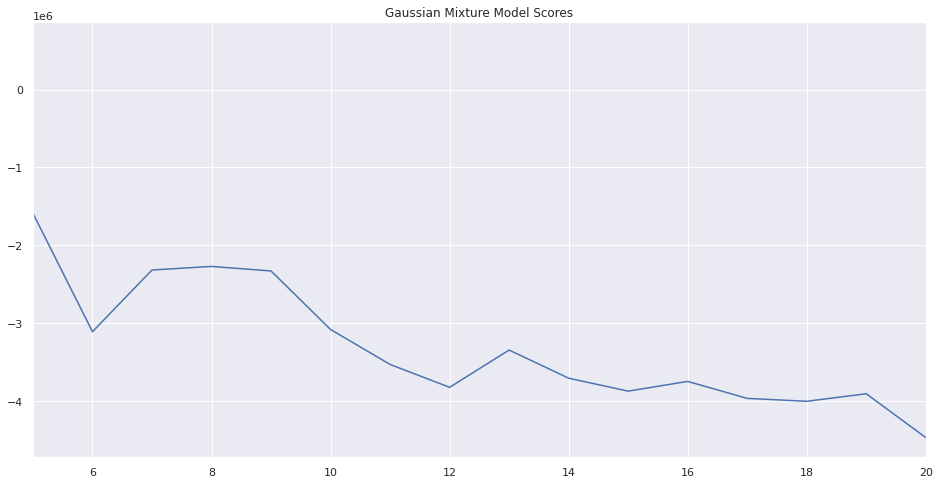

In [23]:
title = 'Gaussian Mixture Model Scores'
figsize = (8, 4)
pd.DataFrame.from_dict(outputs, orient='index').bic.plot(title=title, figsize=(16, 8), xlim=(5, 20))

In [26]:
bic = pd.DataFrame.from_dict(outputs, orient='index').bic
elbow_di = find_elbow(bic)
elbow = elbow_di['elbow']
print(f'Elbow occurs at {elbow} components')
elbow_di['scores']

Elbow occurs at 18 components


,bic,bic_pct_change,bic_pct_change2,criteria_1,criteria_2,criteria_3,criteria_4,criteria_5,score
2,6.076200e+05,NaN,NaN,False,False,False,False,True,1
3,-1.776019e+05,-1.292291,NaN,False,False,False,False,False,0
4,-1.745851e+06,8.830140,-7.832935,True,False,True,True,True,4
5,-1.589300e+06,-0.089670,-1.010155,True,False,False,True,False,2
6,-3.110498e+06,0.957150,-11.674102,True,False,True,True,True,4
7,-2.318042e+06,-0.254768,-1.266174,True,False,False,True,True,3
8,-2.272127e+06,-0.019808,-0.922251,True,False,False,True,False,2
9,-2.330211e+06,0.025564,-2.290578,True,False,False,True,False,2
10,-3.081695e+06,0.322496,11.615420,False,False,True,True,False,2
11,-3.530912e+06,0.145769,-0.547997,True,True,True,True,False,4


### Select model and assemble outputs

In [27]:
selected_gm_model = outputs[elbow]['model']
with open(str(ce_dst), 'wb') as f:
    pickle.dump(ce_model, f)
with open(str(gm_dst), 'wb') as f:
    pickle.dump(selected_gm_model, f)


### Cluster tracts

In [28]:
label_data(df, selected_gm_model).to_pickle(labeled_dst)
label_data(df_orig, selected_gm_model).to_pickle(labeled_orig_dst)